<a href="https://colab.research.google.com/github/Rajarshi1001/dl_tutorial/blob/main/ResNet_34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input
from keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.layers import  Dropout,ZeroPadding2D, Conv2D,LeakyReLU, MaxPool2D, Flatten, Dense, Add, BatchNormalization, Activation,  AveragePooling2D,GlobalAveragePooling2D
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
import pandas as pd
import torchvision
from torchvision.datasets.utils import download_url
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
import tarfile
import os

In [65]:
dataset_url='https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(dataset_url,'.')
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path='./data')
# dataset is opened in the folder format in order to understand the distribution by ploting a barplot.

Total number of images in the dataset :  50000




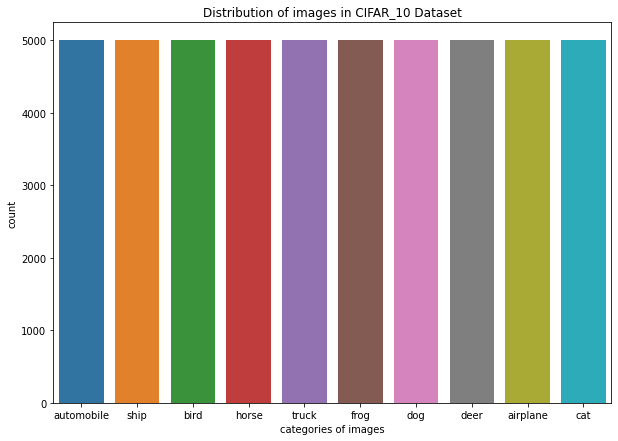

In [66]:
data_url = 'data/cifar10' #dadaset directory
img_list = []
class_list = [] #contains the 10 classes 
train_url = os.path.join(data_url,'train')
train_classes = os.listdir(train_url)
count_dict = {n : 0 for n in train_classes}
for index, label in enumerate(train_classes):
  class_url = os.path.join(train_url, '{}'.format(label))
  class_list.append(class_url)
  for images in os.listdir(class_url):
    img_list.append(images)
    count_dict[label] += 1
df = pd.DataFrame(count_dict, index=[0])
fig, axs = plt.subplots(figsize=(10,7))
ax = sns.barplot(data = df)
sns.set_style('darkgrid')
ax.set(xlabel="categories of images", ylabel="count")
ax.set_title("Distribution of images in CIFAR_10 Dataset")
print('Total number of images in the dataset : ', len(img_list))
print('\n')
#img_list contains the number of images present in the training sample
#count_dict contains the key value pairs of the classes and the number of images belonging to that class in the training sample

In [32]:
(X_train, y_train),(X_test, y_test) = tf.keras.datasets.cifar10.load_data() #loads the dadaset and divides it into training samples and testing samples(numpy array)
X_train_scaled=X_train/255.0 #normalizes the training dataset
X_test_scaled=X_test/255.0 #normalzes the testing sample
y_train_categorical=keras.utils.to_categorical(y_train, num_classes=10, dtype='float32') #converts the class label in the training class in One-Hot encoding format
y_test_categorical=keras.utils.to_categorical(y_test, num_classes=10, dtype='float32') #onverts the class label in the testing class in One-Hot encoding format
y_test_categorical
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

Resnet_34 is a deep learning architecture which uses skip connections to enhance the performance of cnns and also to avoid the vanishing Gradient problem.

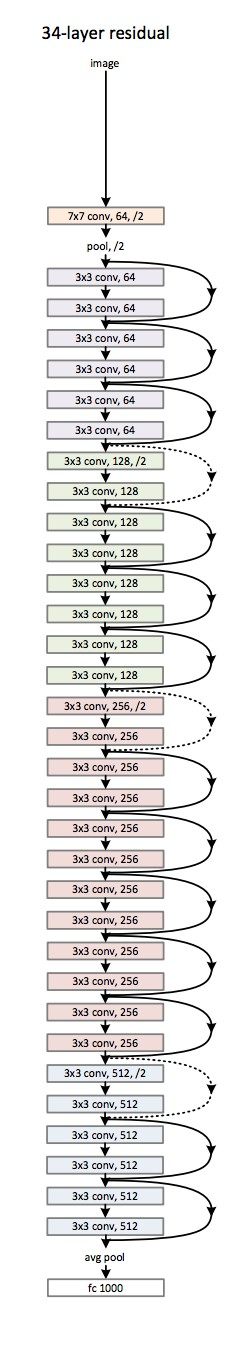

In [33]:
def identity_map(X,filter):
  Shortcut = X
  # Shortcut represent a skip connection that originates from the first layer in a identity_map
  #X represents the output tensor coming fro a convoluted layer that acts as an input tensor in the preojection_map.
  #filter represents the numbers of filters applied to each layer in the projection map for feature extraction.

  F1 = filter 
  #assigns the identical filter size to a particular stage in the network 
  X = Conv2D(filters= F1, kernel_size=(3,3), kernel_initializer="he_uniform",padding="same")(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  
  X = Conv2D(filters= F1, kernel_size=(3,3), kernel_initializer="he_uniform", padding="same")(X)
  X = BatchNormalization()(X)
  X = Add()([X , Shortcut])
  X = Activation('relu')(X)
  # Identity map refers to that the input shape = output shape
  return X

def projection_map(X, filter, stride=(1,1)):
  F1 = filter
  Shortcut = X
  # Shortcut represent a skip connection that originates from the first layer in a projection_map
  '''
  #X represents the output tensor coming fro a convoluted layer that acts as an input tensor in the preojection_map.
  #filter represents the numbers of filters applied to each layer in the projection map for feature extraction.
  #Stride = striding used in the convolution layer to obtain the residual from the input.
  '''
 
  X = Conv2D(filters= F1, kernel_size=(3,3),padding="same",strides=stride)(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(filters= F1, kernel_size=(3,3),padding="same")(X)
  X = BatchNormalization()(X)

  Shortcut = Conv2D(filters = F1 , padding="same", kernel_size=(1,1),strides=stride)(Shortcut)
  Shortcut = BatchNormalization()(Shortcut)

  X = Add()([X , Shortcut])
  X = Activation('relu')(X)
  #projection map is used when the input shape != output shape, 1x1 convoultion layer is attached to the identity_map in projection_map to expand the dimensions
  return X

In [34]:
def resnet(X):
 
 #X = ZeroPadding2D((3, 3))(inputs) 
 X = Conv2D(64,kernel_size=(7,7), strides=(2,2),kernel_initializer="glorot_uniform")(X)
 #X = BatchNormalization(axis=3)
 #X = Activation('relu')(X)
 X = MaxPool2D(strides=(2,2), padding="same")(X)

 X = identity_map(X,64)
 X = identity_map(X,64)
 X = identity_map(X,64)

 X = projection_map(X,128,(2,2))

 X = identity_map(X,128)
 X = identity_map(X,128)
 X = identity_map(X,128)

 X = projection_map(X,256,(2,2))

 X = identity_map(X,256)
 X = identity_map(X,256)
 X = identity_map(X,256)
 X = identity_map(X,256)
 X = identity_map(X,256)

 X = projection_map(X,512,(2,2))
 X = identity_map(X,512)
 X = identity_map(X,512)
 X = GlobalAveragePooling2D()(X)
 X = Dense(10, activation="softmax")(X)
 # output channels = 10 because there are 10 classes in the dataset.
 #model1= Model(inputs = input, outputs = outputs)
 
 return X


In [60]:
print(model.summary())
val_imgs = X_train_scaled[-3000 : ]
val_label = y_train[-3000 : ]
img_tensor = Input(shape=[32,32,3])
var = resnet_34(img_tensor)
model = Model(inputs = img_tensor, outputs = var)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
hist = model.fit(X_train_scaled, y_train, epochs = 100, batch_size = 64, validation_data=(val_imgs, val_label))
#hist stores the entire histore of training acc, training loss, val_acc , val_loss.

#this is the first training of the model with 100 epochs ...

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 11,121,418
Trainable params: 11,112,202
Non-trainable params: 9,216
__________________________________________________________________________________________________
None
Epoch 1/100
782/782 [==============================] - 19s 22ms/step - loss: 1.8688 - accuracy: 0.3071 - val_loss: 1.3607 - val_accuracy: 0.5153
Epoch 2/100
782/782 [==============================] - 16s 21ms/step - loss: 1.3174 - accuracy: 0.5247 - val_loss: 1.0767 - val_accuracy: 0.6047
Epoch 3/100
782/782 [==============================] - 16s 21ms/step - loss: 1.0952 - accuracy: 0.6112 - val_loss: 0.9325 - val_accuracy: 0.6660
Epoch 4/100
782/782 [==============================] - 16s 21ms/step - loss: 0.9274 - accuracy: 0.6715 - val_loss: 0.8103 - val_accuracy: 0.7160
Epoch 5/100
782/78

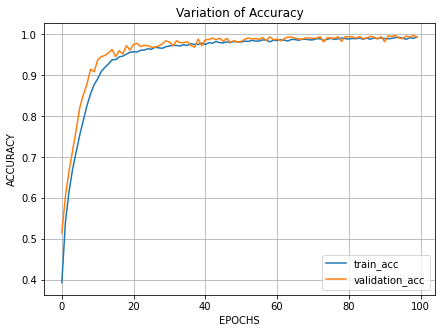

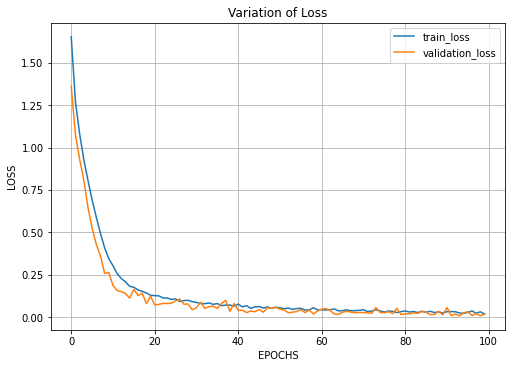

In [63]:
epoch = range(100)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
validation_acc = hist.history['val_accuracy']
validation_loss = hist.history['val_loss']
#fig ,ax= plt.subplots(nrows=1,ncols=2)

#This plot shows the variation of training accuracy and the validation accuracy with epochs
fig = plt.figure(figsize=(7,5))
plt.plot(epoch, train_acc)
plt.plot(epoch, validation_acc)
plt.xlabel("EPOCHS")
plt.ylabel("ACCURACY")
plt.title("Variation of Accuracy")
plt.legend(['train_acc','validation_acc'])
plt.grid()


#This plot shows the variation of training loss and the validation loss with epochs
fig = plt.figure(figsize=(7,5))
plt.plot(epoch, train_loss)
plt.plot(epoch, validation_loss)
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")
plt.title("Variation of Loss")
plt.legend(['train_loss', 'validation_loss'])
plt.grid()
fig.tight_layout(pad=0.3)

In [64]:
results = model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 2.5194 - accuracy: 0.6766


In [37]:
print(model.summary())
val_imgs = X_train_scaled[-3000 : ]
val_label = y_train[-3000 : ]
img_tensor = Input(shape=[32,32,3])
var = resnet_34(img_tensor)
model = Model(inputs = img_tensor, outputs = var)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
hist = model.fit(X_train_scaled, y_train, epochs = 40, batch_size = 64, validation_data=(val_imgs, val_label))
#hist stores the entire histore of training acc, training loss, val_acc , val_loss.

#this is the second training of the model with 50 epochs

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 11,121,418
Trainable params: 11,112,202
Non-trainable params: 9,216
__________________________________________________________________________________________________
None
Epoch 1/50
782/782 [==============================] - 19s 21ms/step - loss: 1.9319 - accuracy: 0.2691 - val_loss: 1.3850 - val_accuracy: 0.4963
Epoch 2/50
782/782 [==============================] - 16s 21ms/step - loss: 1.3310 - accuracy: 0.5182 - val_loss: 1.1249 - val_accuracy: 0.5920
Epoch 3/50
782/782 [==============================] - 16s 21ms/step - loss: 1.1323 - accuracy: 0.5917 - val_loss: 0.9511 - val_accuracy: 0.6597
Epoch 4/50
782/782 [==============================] - 16s 21ms/step - loss: 0.9585 - accuracy: 0.6600 - val_loss: 0.8197 - val_accuracy: 0.7120
Epoch 5/50
782/782 [===

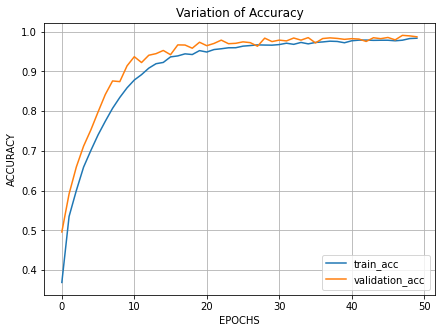

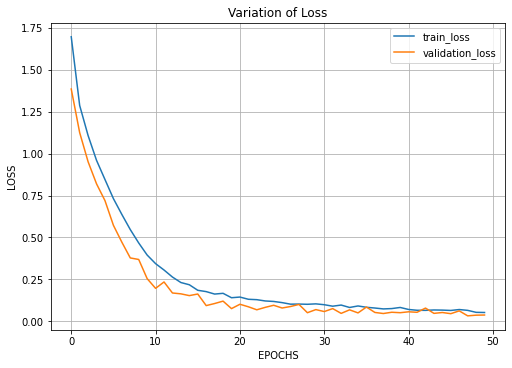

In [50]:
epoch = range(50)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
validation_acc = hist.history['val_accuracy']
validation_loss = hist.history['val_loss']
#fig ,ax= plt.subplots(nrows=1,ncols=2)

#This plot shows the variation of training accuracy and the validation accuracy with epochs
fig = plt.figure(figsize=(7,5))
plt.plot(epoch, train_acc)
plt.plot(epoch, validation_acc)
plt.xlabel("EPOCHS")
plt.ylabel("ACCURACY")
plt.title("Variation of Accuracy")
plt.legend(['train_acc','validation_acc'])
plt.grid()


#This plot shows the variation of training loss and the validation loss with epochs
fig = plt.figure(figsize=(7,5))
plt.plot(epoch, train_loss)
plt.plot(epoch, validation_loss)
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")
plt.title("Variation of Loss")
plt.legend(['train_loss', 'validation_loss'])
plt.grid()
fig.tight_layout(pad=0.3)

In [53]:
results = model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 2.0453 - accuracy: 0.6711
